![image.png](https://i.imgur.com/a3uAqnb.png)

# **📌 Custom Dataset Class & Image Augmentations**
---

## **Working with Ready-to-Use Datasets**
So far, we've worked with **ready-to-use datasets** like:
```python
from torchvision.datasets import MNIST, CIFAR10
train_dataset = MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
```
These datasets are predefined in PyTorch, and we don't need to worry about loading images manually.

## **What If We Have Raw Images in a Folder?**
What if we have:
-  Images inside a folder?
-  Raw images without predefined labels?
-  Custom datasets collected manually?

How do we load and prepare them for a PyTorch model?

#### Let's start with this dataset. It is about Flowers Recognition:

In [9]:

#IMPORTANT IN KAGGLE YOU HAVE TO USE IT

# # Please uncomment this out when you are running this lab on google colab!
import os

# # Set KaggleHub cache to a directory inside /content/
os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [2]:
import kagglehub #dataset in file

# Download dataset
path = kagglehub.dataset_download("alxmamaev/flowers-recognition") # 5 classes so it's multi-class classification

print("Path to dataset files:", path)

Path to dataset files: /content/data/datasets/alxmamaev/flowers-recognition/versions/2


## **1️⃣ First Step: How to Read an Image?**
Before working with a dataset, we need to know how to **read a single image**.

In [ ]:
#to relocate the path into current directory that I opened it:
#mv /content/data/datasets/alxmamaev/flowers-recognition/versions/2 .

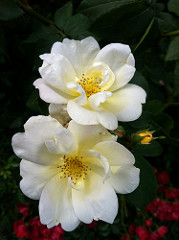

In [3]:
### *📌 Loading Images Using PIL (Pillow)*
### Pillow (`PIL`) is a common Python library for handling images.
from PIL import Image #or cv2
import os

# Load an image
image_path = os.path.join(path,"flowers/rose/10090824183_d02c613f10_m.jpg")# os.pth.join it's combining paths(concatonation the path with the image name)
image = Image.open(image_path)# open the image to read it

# Display the image
image

## **2️⃣ Second Step: Finding Paths of All Images in a Folder**
To load an entire dataset, we need a **list of all image paths** inside a folder.

This could be achieved by glob.

In [4]:
import glob
folder_path = os.path.join(path, "flowers", "daisy", "*.jpg") #every jpg paths in the folder

# Get paths of all .jpg images
image_files = glob.glob(folder_path) #it gives us the paths so I can read them later
print(image_files[:5])




# the main thing that we want to achieve to finish data class is to get:
# List or pd series of all paths
        #(glob + glob + glob) of each class so it will gives all paths
# another list or pd series of all Labels (segemntation : Lables/masks) (Object detection: bounding boxes/classes)
     # create a list with zeros or ones or twos and multiply it with the length of paths in the folder
            #rose_paths_images = glob.glob("folder path here") #all the images lables is 2
             #[2]*len(rose_paths_images) #because they are roses so give the list number 2, and do it for all the 5 classes each one take any number 0-4, then sum them up

['/content/data/datasets/alxmamaev/flowers-recognition/versions/2/flowers/daisy/3695826945_9f374e8a00_m.jpg', '/content/data/datasets/alxmamaev/flowers-recognition/versions/2/flowers/daisy/20773528301_008fcbc5a1_n.jpg', '/content/data/datasets/alxmamaev/flowers-recognition/versions/2/flowers/daisy/14816364517_2423021484_m.jpg', '/content/data/datasets/alxmamaev/flowers-recognition/versions/2/flowers/daisy/8127252886_96558c23d1.jpg', '/content/data/datasets/alxmamaev/flowers-recognition/versions/2/flowers/daisy/12701063955_4840594ea6_n.jpg']


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


✅ **Now we have the full path for each image!**

## **3️⃣ Third Step: How to convert these images to tensors?**
PyTorch models require **tensors**, not raw images.  
To convert an image to a tensor, we use **`transforms.ToTensor()`**.

In [6]:
from torchvision import transforms

# Define transformation
transform = transforms.ToTensor()

# Load and convert image to tensor
image = Image.open(image_files[0]) #read it then apply the tensor
image_tensor = transform(image)

# Show tensor shape
print(image_tensor.shape)  # (Channels, Height, Width)

torch.Size([3, 240, 207])


### ✅ **Great! This should be ready to be fed into a model, right?**  
####  **Sorry, life is not that easy.🫠**

## **📌 Do All Images Have the Same Shape?**
Before passing images to a model, we must ensure:
- **All images have the same size** (Height and Width)
- **No missing channels** (e.g., grayscale vs. RGB)

In [7]:
# Check shape of multiple images
for image_path in image_files[:5]:  # Check first 5 images
    img = Image.open(image_path)
    print(f"Image: {image_path}, Shape: {img.size}")  # Prints (Width, Height)

Image: /content/data/datasets/alxmamaev/flowers-recognition/versions/2/flowers/daisy/3695826945_9f374e8a00_m.jpg, Shape: (207, 240)
Image: /content/data/datasets/alxmamaev/flowers-recognition/versions/2/flowers/daisy/20773528301_008fcbc5a1_n.jpg, Shape: (320, 213)
Image: /content/data/datasets/alxmamaev/flowers-recognition/versions/2/flowers/daisy/14816364517_2423021484_m.jpg, Shape: (180, 240)
Image: /content/data/datasets/alxmamaev/flowers-recognition/versions/2/flowers/daisy/8127252886_96558c23d1.jpg, Shape: (500, 299)
Image: /content/data/datasets/alxmamaev/flowers-recognition/versions/2/flowers/daisy/12701063955_4840594ea6_n.jpg, Shape: (320, 240)


## **📌 Why Do We Need Image Transformations?**
Ok, we can see now that we have to **resize all the images into the same size**.  
Otherwise, models wouldn't work because **they expect fixed input dimensions**.

But resizing is not the only operation we could do!  
We could also:
- **Convert an image to grayscale** 📷  
- **Crop the image** ✂️  
- **Rotate the image** 🔄  
- **Apply brightness adjustments** 💡  
- **Add noise for robustness** 🎭
- For others: https://pytorch.org/vision/0.10/transforms.html

PyTorch provides `torchvision.transforms` to easily apply these transformations.

These transformations, when applied on training data, are often called: **Augmentations**.

Augmentations are **image transformations** applied to:

✅ Improve **generalization** (prevent overfitting).  
✅ Increase **data variability** (expand dataset artificially).  
✅ Improve **robustness** (make the model handle different conditions).


Let's firstly try to resize the images we have above and convert them to grayscale.

In [8]:
from torchvision import transforms

# Define transformation
transform = transforms.Compose([ #compose means do the operations in order
    transforms.Grayscale(),       # Make all the images gray scale #one type of shape. GreyScale to RGB -> concatonation 3 times (Greyscale repeat it 3 times)
    transforms.Resize((64, 64)),  # Resize all images to 64x64, it can be another number but it would take more time
    transforms.ToTensor() #tensor usually at the end then normalization
])

# Load and convert image
for i in range(10): #not one image
    image = Image.open(image_files[i])#here it on folder
    image_tensor = transform(image)

    # Show tensor shape
    print(image_tensor.shape)  # (Channels, Height, Width)

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


✅ **Now, our images are consistent!**

# **📌 Let's Work with the Full Dataset**
Now, let's apply what we've learned to the **full dataset**.

Given you are working with torch, you can make a code for only **One Sample** and it should work for the whole dataset. So let's do that!

---

## **1️⃣ Understanding the Dataset Structure**
We have a **flower classification dataset** stored in the following structure:

```
flowers-recognition/
│── flowers/
│   │── daisy/
│   │── dandelion/
│   │── rose/
│   │── sunflower/
│   │── tulip/
```
Each folder contains images of the respective flower type.

---

## **2️⃣ Assigning Labels to Classes**
We have **5 categories**, so we assign **numerical labels** to them:

| Flower Name   | Label |
|--------------|-------|
| Daisy        | `0`   |
| Dandelion    | `1`   |
| Rose         | `2`   |
| Sunflower    | `3`   |
| Tulip        | `4`   |

#### ✅ **Our goal**: Read each image, apply transformations, and return both the **image** and its **corresponding label**.

---

## **3️⃣ First Step: Get the Paths of Each Class**
Before working with all images, let's focus on **one sample** then just make a loop.

In [3]:
import glob
import os
from PIL import Image
import torchvision.transforms as transforms

# Get all image paths from one category (e.g., Daisy)
category = "daisy"
folder_path = os.path.join(path, "flowers", category, "*.jpg")
image_paths = glob.glob(folder_path)#the whole path for Daisy folder

# Load one image
sample_image_path = image_paths[0]  # Take the first image
image = Image.open(sample_image_path)  # Open image

# Print original image size and channels
print(f"Original Image Size: {image.size}, Mode: {image.mode}")  # Mode is "RGB" for color images

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor(),  # Convert to tensor
])

# Apply transformations
image_tensor = transform(image)

# Print transformed image shape
print(f"Transformed Image Shape: {image_tensor.shape}")  # (Channels, Height, Width)

# Define class labels
class_labels = {"daisy": 0, "dandelion": 1, "rose": 2, "sunflower": 3, "tulip": 4}
label = class_labels[category]

print(f"Image Label: {label}")  # Output: 0 (Daisy)

Original Image Size: (207, 240), Mode: RGB
Transformed Image Shape: torch.Size([1, 64, 64])
Image Label: 0


#### ✅ **Now, we have an image and its corresponding label!**  

# **📌 From Single Image Processing to a Dataset Class**
In the previous step, we **converted one image** from a raw format into a **model-ready tensor** with a label.

✅ But we don’t want to do this manually for every image.  
✅ Instead, we should **automate** this process inside `__getitem__()` in a **Dataset Class**.


---

# **📌 Let's See How a Dataset Class Looks**
A PyTorch Dataset class typically consists of **three main functions**:

| Function       | Purpose |
|---------------|------------------------------------------------|
| `__init__()`  | Loads all image paths & stores class labels. |
| `__len__()`   | Returns the total number of images. |
| `__getitem__()` | Loads, processes, and returns one image & label. |


#### Essentially, what we wrote earlier **should now go inside `__getitem__()`!**  

In [4]:
### **🔹 General Structure of a Dataset Class**
from torch.utils.data import Dataset
from PIL import Image
import glob
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir  # Dataset path
        self.transform = transform  # Transformations
        self.class_labels = {"daisy": 0, "dandelion": 1, "rose": 2, "sunflower": 3, "tulip": 4}
        # Get all image paths
        self.image_paths = []
        self.labels = []
        for class_name, label in self.class_labels.items():#the loop is assign a label to each image
            class_images = glob.glob(f"{root_dir}/{class_name}/*.jpg")  # Find all images
            self.image_paths.extend(class_images)#extend it into the array initialized at some point
            self.labels.extend([label] * len(class_images))  # Assign labels, in SEGMENTATION we put here masks paths too not lables

    def __len__(self):
        return len(self.image_paths)  # Total number of images

    def __getitem__(self, idx): #idx is the input or the number of image i want to get with it's label
        image_path = self.image_paths[idx]  # Get image path
        label = self.labels[idx]  # Get label

        # Load image using PIL
        image = Image.open(image_path) # in segmentation we load masks too
        # mask = Image.open(mask_path)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)
        return image, label  # Return processed image & label, in SEGMENTATION we return image, mask

In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Grayscale
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.ToTensor(),  # Convert image to tensor
])

# Initialize it
dataset = CustomDataset(root_dir=os.path.join(path, "flowers") , #we used the same path earlier
                       transform=transform)

#### ✅ Now, **every time we call `dataset[idx]`, it will return an image & label, processed automatically!**  

---

# **📌 But Wait... This Reads One Image at a Time!**
Right now, our **Dataset Class** loads **one image at a time** when we call:
```python
image, label = dataset[0]  # Loads only one image
```
✅ **That’s great for understanding**, but when training a model, we need to process **multiple images at once** for efficiency.

❌ **Problem**: We need batches, not single images.  
✅ **Solution**: We use `DataLoader` to handle batching automatically.

# **📌 Introducing `DataLoader`**
A **DataLoader** helps in:
- **Batching**: Groups multiple samples together for faster processing.
- **Shuffling**: Randomizes data order to improve training.
- **Multi-threading**: Loads data efficiently in parallel.

| **Argument**     | **Description** |
|-----------------|---------------|
| `dataset` | The dataset object (e.g., `train_dataset`) |
| `batch_size` | Number of samples per batch (e.g., `32`) |
| `shuffle` | Whether to **randomly shuffle** data each epoch (`True` = better for training) |
| `num_workers` | Number of parallel **CPU workers** to load data faster |
| `collate_fn` | A function to **customize how data is stacked** (useful when data has variable sizes) |


![image.png](https://i.imgur.com/aHE3lnE.png)

In [6]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32

# Create DataLoader
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)#our custom dataset

# Get a batch of training images
images, labels = next(iter(train_loader))#next and iter ,iterate through the dataloader to iterate over each batch, and next helps to get the next batch.
print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 1, 64, 64]), Labels: tensor([3, 0, 2, 0, 1, 2, 1, 4, 2, 4, 2, 1, 4, 2, 2, 0, 1, 3, 4, 2, 1, 0, 2, 3,
        0, 0, 0, 3, 2, 2, 4, 1])


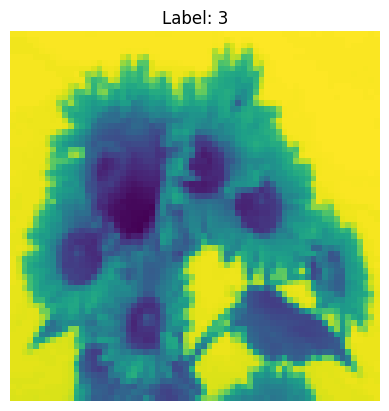

In [23]:
#for i in dataset:
    #print(i)

#dataset[0]
import torchvision.transforms as transfroms
import matplotlib.pyplot as plt

image_tensor =images[0]
label = labels[0].item()

to_pil = transfroms.ToPILImage()
image_pil = to_pil(image_tensor)

plt.imshow(image_pil)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

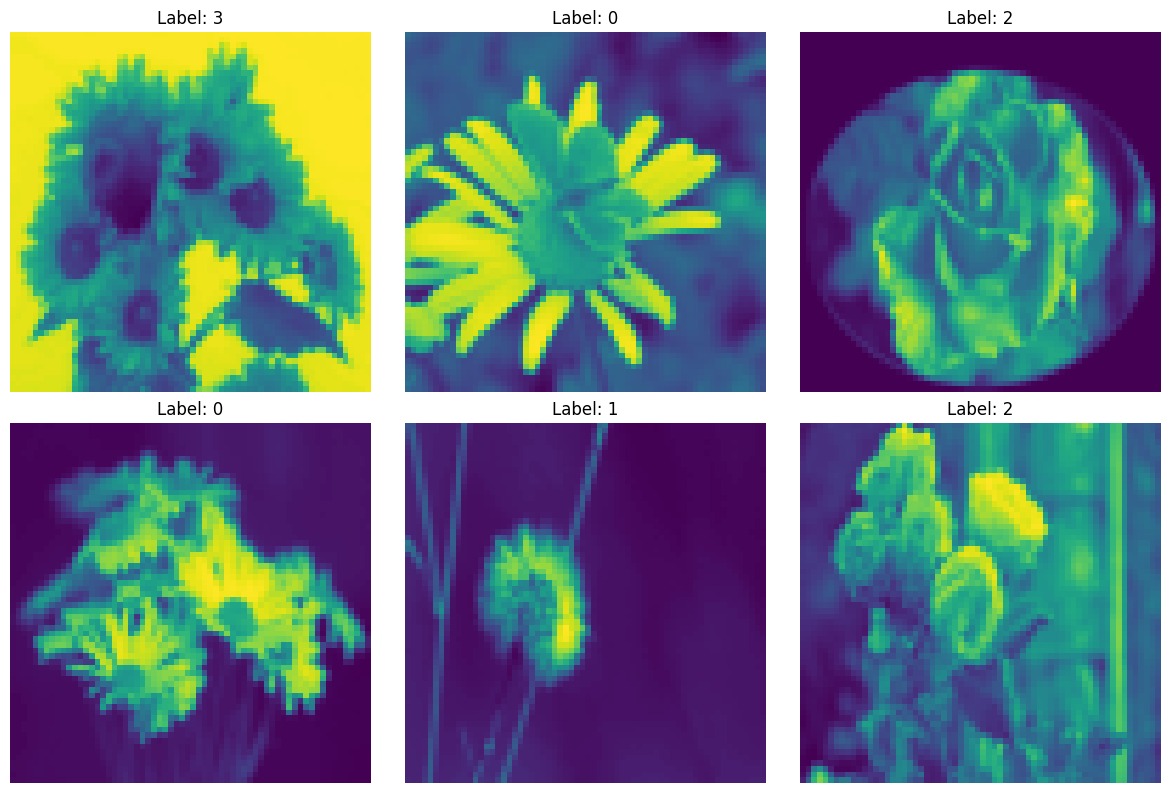

In [24]:
# Define the number of images to display
num_images = min(6, len(images))  # Ensures we don't exceed batch size

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 3 columns

# Convert images and plot them
to_pil = transforms.ToPILImage()

for i in range(num_images):
    img = to_pil(images[i])  # Convert to PIL
    label = labels[i].item()  # Convert tensor to int if needed
    ax = axes[i // 3, i % 3]  # Position in the grid
    ax.imshow(img)
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

#### ✅ **Now, instead of reading one image at a time, we process an entire batch! This can be now fed into a model.**

---

# Another Example

# **📌 Skin Cancer ISIC Dataset**
We will now work with the **Skin Cancer ISIC** dataset, which contains images of different skin lesions.

---

# **📌 Dataset Structure**
The dataset consists of **two folders**:  
✅ `Train/` → Contains images for training.  
✅ `Test/` → Contains images for evaluation.

Each folder contains **9 categories of skin lesions**:

```
Skin_Cancer_ISIC/
│── Train/
│   │── actinic keratosis/
│   │── basal cell carcinoma/
│   │── dermatofibroma/
│   │── melanoma/
│   │── nevus/
│   │── pigmented benign keratosis/
│   │── seborrheic keratosis/
│   │── squamous cell carcinoma/
│   │── vascular lesion/
│── Test/
│   │── actinic keratosis/
│   │── basal cell carcinoma/
│   │── dermatofibroma/
│   │── melanoma/
│   │── nevus/
│   │── pigmented benign keratosis/
│   │── seborrheic keratosis/
│   │── squamous cell carcinoma/
│   │── vascular lesion/
```

✅ **Each folder represents a different type of skin lesion.**  
✅ **Our goal** is to classify images into these 9 categories.

---

# **📌 Assigning Labels**
We assign a **numerical label** to each class:

| Skin Lesion Name                 | Label |
|----------------------------------|------|
| Actinic Keratosis               | `0`  |
| Basal Cell Carcinoma            | `1`  |
| Dermatofibroma                  | `2`  |
| Melanoma                        | `3`  |
| Nevus                           | `4`  |
| Pigmented Benign Keratosis      | `5`  |
| Seborrheic Keratosis            | `6`  |
| Squamous Cell Carcinoma         | `7`  |
| Vascular Lesion                 | `8`  |

✅ **Now, let’s define the dataset class!**

---

In [25]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

print("Path to dataset files:", path)

100%|██████████| 786M/786M [00:09<00:00, 91.3MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/nodoubttome/skin-cancer9-classesisic/versions/1


In [26]:
from torch.utils.data import Dataset
from PIL import Image
import glob

class SkinCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir  # Dataset path
        self.transform = transform  # Transformations
        self.class_labels = {
            "actinic keratosis": 0, "basal cell carcinoma": 1, "dermatofibroma": 2,
            "melanoma": 3, "nevus": 4, "pigmented benign keratosis": 5,
            "seborrheic keratosis": 6, "squamous cell carcinoma": 7, "vascular lesion": 8
        }
        # Get all image paths
        self.image_paths = []
        self.labels = []
        for class_name, label in self.class_labels.items():
            class_images = glob.glob(f"{root_dir}/{class_name}/*.jpg")  # Find all images
            self.image_paths.extend(class_images)
            self.labels.extend([label] * len(class_images))  # Assign labels

    def __len__(self):
        return len(self.image_paths)  # Total number of images

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]  # Get image path
        label = self.labels[idx]  # Get label

        # Load image using PIL
        image = Image.open(image_path)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label  # Return processed image & label

In [27]:
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images
    transforms.RandomRotation(15),  # Rotate images randomly within ±15 degrees , up to 15
    transforms.ColorJitter(brightness=0.2),  # Adjust brightness randomly, up t0 0.2
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),  # value for each channel
])
# Validation and testing data typically don’t require augmentations, as we only evaluate the model performance on these sets.
# Instead, we apply basic transformations to prepare the images.
transform_valid_test = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),#RGB colors so we normalize each channel of image, if greyscale [0.5] it's 1
])

# Initialize dataset for Train
#if it's not split in folders as train, test folder split it as numbers :
# self.images = os.listdir(img_dir)[:2300] this is in dataset class
#or write it outside for train: train= image path[:1000] # for test: test = image_path[1000:]
train_path = os.path.join(path, "Skin cancer ISIC The International Skin Imaging Collaboration", "Train")
test_path = os.path.join(path, "Skin cancer ISIC The International Skin Imaging Collaboration", "Test")

train_dataset = SkinCancerDataset(train_path, transform=transform)
test_dataset = SkinCancerDataset(test_path, transform=transform_valid_test)#test data not transformed

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)#shuffle in test too

# Get a batch of training images
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 3, 64, 64]), Labels: tensor([1, 3, 4, 3, 3, 1, 2, 3, 1, 5, 4, 8, 4, 3, 3, 1, 3, 7, 3, 4, 8, 5, 4, 4,
        0, 6, 5, 5, 6, 0, 1, 8])


## **🔹 Now You Know How to Split into Train and Test!**
To create training and testing datasets, we **split the image paths** and create **two datasets and two dataloaders**.


## 📌 **Another easier approach for datasets organized in subfolders**

When working with **image classification datasets** organized in subfolders, **`ImageFolder`** is a great **built-in PyTorch dataset loader** that automatically assigns labels based on folder names.

---

**Dataset Structure Expected by `ImageFolder`:**
```
Dataset/
│── Class_A/
│   │── image_1.jpg
│   │── image_2.jpg
│── Class_B/
│   │── image_3.jpg
│   │── image_4.jpg
```
- **Class names (folder names) become labels** (`Class_A = 0`, `Class_B = 1`)
- **No need to manually extract file paths and labels!**

---






Given our dataset here follow this structure, we can, instead of writing a custom `Dataset` class, **directly load images** using `ImageFolder`!

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder # if you have dataset that each class in folder
import os
# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images
    transforms.RandomRotation(15),  # Rotate images randomly within ±15 degrees
    transforms.ColorJitter(brightness=0.2),  # Adjust brightness randomly
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),  # value for each channel
])

# Validation and testing data typically don’t require augmentations, as we only evaluate the model performance on these sets.
# Instead, we apply basic transformations to prepare the images.
transform_valid_test = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

# Initialize dataset for Train
train_path = os.path.join(path, "Skin cancer ISIC The International Skin Imaging Collaboration", "Train")
test_path = os.path.join(path, "Skin cancer ISIC The International Skin Imaging Collaboration", "Test")

train_dataset = ImageFolder(train_path, transform=transform)   #pass ImageFolder here, equivelant to Dataset class that has len and getitem        ## Replaced SkinCancerDataset with ImageFolder
test_dataset = ImageFolder(test_path, transform=transform_valid_test)                                    ## Replaced SkinCancerDataset with ImageFolder

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Get a batch of training images
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 3, 64, 64]), Labels: tensor([7, 5, 2, 6, 3, 0, 0, 7, 6, 1, 3, 0, 3, 7, 3, 4, 4, 8, 4, 5, 4, 7, 0, 5,
        1, 7, 3, 7, 5, 4, 6, 1])


#### That's it! No need for a custom dataset class here!

# **📌 Handling Datasets with Non-Standard Structures**
Sometimes, datasets are structured in **non-standard ways**, making it harder to assign labels directly from folder names.  


### **Example: Weird Dataset Structure**
In this case, instead of having separate folders for `smoking` and `notsmoking`, the filenames themselves indicate the class:

```
Smoking_Dataset/
│── Training/
│   │── Training/
│   │   │── notsmoking_0006.jpg
│   │   │── smoking_0007.jpg
│── Validation/
│   │── Validation/
│   |   │── notsmoking_0012.jpg
│   |   │── smoking_0015.jpg
│── Testing/
│   │── Testing/
│   |   │── notsmoking_0032.jpg
│   |   │── smoking_0034.jpg
```

---

In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sujaykapadnis/smoking")

print("Path to dataset files:", path)

100%|██████████| 63.8M/63.8M [00:00<00:00, 153MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/sujaykapadnis/smoking/versions/5


- Let's extract the labels outside the dataset class for simplicity

In [6]:
import os
import glob
from tqdm import tqdm

# Define dataset path
dataset_path = os.path.join(path, "Training", "Training")
# Get all image paths
train_image_paths = glob.glob(f"{dataset_path}/*.jpg")

# Define dataset path
dataset_path = os.path.join(path, "Validation", "Validation")
# Get all image paths
valid_image_paths = glob.glob(f"{dataset_path}/*.jpg")

# Define dataset path
dataset_path = os.path.join(path, "Testing", "Testing")
# Get all image paths
test_image_paths = glob.glob(f"{dataset_path}/*.jpg")

train_labels = []
valid_labels = []
test_labels = []

for path in tqdm(train_image_paths): #split the images from labels, they are in the same folder i guess
    prefix  = path.split("/")[-1].split("_")[0]                 # "./Training/smoking_0007.jpg" → "smoking_0007.jpg"  → "smoking"
    label = 1 if prefix == "smoking" else 0                     # Assign label
    train_labels.append(label)                                  # Store label

for path in tqdm(valid_image_paths): #repeated because
    prefix = path.split("/")[-1].split("_")[0]
    label = 1 if prefix == "smoking" else 0
    valid_labels.append(label)

for path in tqdm(test_image_paths):
    prefix = path.split("/")[-1].split("_")[0]
    label = 1 if prefix == "smoking" else 0
    test_labels.append(label)

100%|██████████| 224/224 [00:00<00:00, 400138.03it/s]


✅ Now, image paths and labels are ready for the dataset class! 🎯

In [7]:
from torch.utils.data import Dataset
from PIL import Image

class SmokingDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths  # List of image paths
        self.labels = labels  # Corresponding labels
        self.transform = transform  # Transformations to apply

    def __len__(self):
        return len(self.image_paths)  # Total number of images

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]  # Get image path
        label = self.labels[idx]  # Get corresponding label

        # Load image
        image = Image.open(image_path)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label  # Return processed image and its label

In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])


transform_valid_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

# Initialize datasets
train_dataset = SmokingDataset(train_image_paths, train_labels, transform=transform)
valid_dataset = SmokingDataset(valid_image_paths, valid_labels, transform=transform_valid_test)
test_dataset = SmokingDataset(test_image_paths, test_labels, transform=transform_valid_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get a batch of training images
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 1])


## **📌 Final Note: Data Formats Can Vary**
When working with datasets, **the structure may differ** based on how the labels are stored.  

✅ **Common ways labels are provided**:
- **Folder names** → Each folder represents a class (as we saw).
- **CSV file** → Labels are stored in a `data.csv` file with filenames.
- **JSON file** → Labels are stored in a `labels.json` file.
- **Separate annotation files** → Some datasets use `.txt` or `.xml` annotations.

### **🔹 How to Handle This?**
✅ **Always explore the dataset structure first** before writing code.  
✅ Check:
- 📂 **Are images inside class folders?**
- 📄 **Is there a CSV/JSON file with labels?**
- 🔄 **Do filenames contain class names?**

Once you understand the dataset, **write the correct logic to retrieve paths and labels.**  


# **📌 Exercise: Build a Dataset Class for Horse Breeds**

https://www.kaggle.com/datasets/olgabelitskaya/horse-breeds

In [33]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")

print("Path to dataset files:", path)

100%|██████████| 82.0M/82.0M [00:00<00:00, 130MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/olgabelitskaya/horse-breeds/versions/27


In [90]:
#####THE LABELS ARE IN FILE PATHS
# Import necessary libraries
image_dict = {}
# Define the list of file names
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()
import os
import pandas as pd
# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile
# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

MIN_SAMPLES = 100 # only include labels with as many samples
# Initialize empty lists to store file names and labels
file_names = []
labels = []
labels_dict = {'01': 'Akhal-Teke', '02': 'Appaloosa', '03': 'Orlov Trotter', '04': 'Vladimir Heavy Draft', '05': 'Percheron',
'06': 'Arabian', '07': 'Friesian'}
# Iterate through all image files in the specified directory
#for file in sorted((Path('/kaggle/input/horse-breeds/').glob('*.png'))):
for file in sorted((Path('/content/data/datasets/olgabelitskaya/horse-breeds/versions/27').glob('*.png'))):
    # check number of such files in a directory
    sample_dir = '/'.join(str(file).split('/')[:-1])+'/'
    num_files_in_dir = [len(x) for _, _, x in os.walk(sample_dir)][0]
    if num_files_in_dir >= MIN_SAMPLES:
        file_names.append(str(file))  # Add the file path to the list
        label = labels_dict[str(file).split('/')[-1][:2]]  # Extract the label from the file
        labels.append(label)  # Add the label to the list
print(len(file_names), len(labels))



#NOT necessary
# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"label": labels, "image": file_names})

labels = list(df['label'].values)
print(df.shape)


df

670 670
(670, 2)


label                                              image
0    Akhal-Teke  /content/data/datasets/olgabelitskaya/horse-br...
1    Akhal-Teke  /content/data/datasets/olgabelitskaya/horse-br...
2    Akhal-Teke  /content/data/datasets/olgabelitskaya/horse-br...
3    Akhal-Teke  /content/data/datasets/olgabelitskaya/horse-br...
4    Akhal-Teke  /content/data/datasets/olgabelitskaya/horse-br...
..          ...                                                ...
665    Friesian  /content/data/datasets/olgabelitskaya/horse-br...
666    Friesian  /content/data/datasets/olgabelitskaya/horse-br...
667    Friesian  /content/data/datasets/olgabelitskaya/horse-br...
668    Friesian  /content/data/datasets/olgabelitskaya/horse-br...
669    Friesian  /content/data/datasets/olgabelitskaya/horse-br...

[670 rows x 2 columns]

In [91]:
from torch.utils.data import Dataset
from PIL import Image

class HorseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths  # List of image paths
        self.labels = labels  # Corresponding labels
        self.transform = transform  # Transformations to apply

    def __len__(self):
        return len(self.image_paths)  # Total number of images

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]  # Get image path
        label = self.labels[idx]  # Get corresponding label

        # Load image
        image = Image.open(image_path)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label  # Return processed image and its label

In [92]:
# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Grayscale
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.ToTensor(),  # Convert image to tensor
])

# Initialize it
dataset = HorseDataset(image_paths=file_names, labels=labels, transform=transform)

In [93]:
# Create DataLoaders
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Get a batch of training images
images, labels = next(iter(data_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 1, 64, 64]), Labels: ('Appaloosa', 'Akhal-Teke', 'Appaloosa', 'Akhal-Teke', 'Friesian', 'Friesian', 'Akhal-Teke', 'Orlov Trotter', 'Friesian', 'Akhal-Teke', 'Appaloosa', 'Appaloosa', 'Appaloosa', 'Orlov Trotter', 'Akhal-Teke', 'Orlov Trotter', 'Friesian', 'Akhal-Teke', 'Friesian', 'Percheron', 'Orlov Trotter', 'Akhal-Teke', 'Friesian', 'Arabian', 'Friesian', 'Arabian', 'Akhal-Teke', 'Orlov Trotter', 'Orlov Trotter', 'Appaloosa', 'Orlov Trotter', 'Akhal-Teke')


In [99]:
print(labels[:5])

('Appaloosa', 'Akhal-Teke', 'Appaloosa', 'Akhal-Teke', 'Friesian')


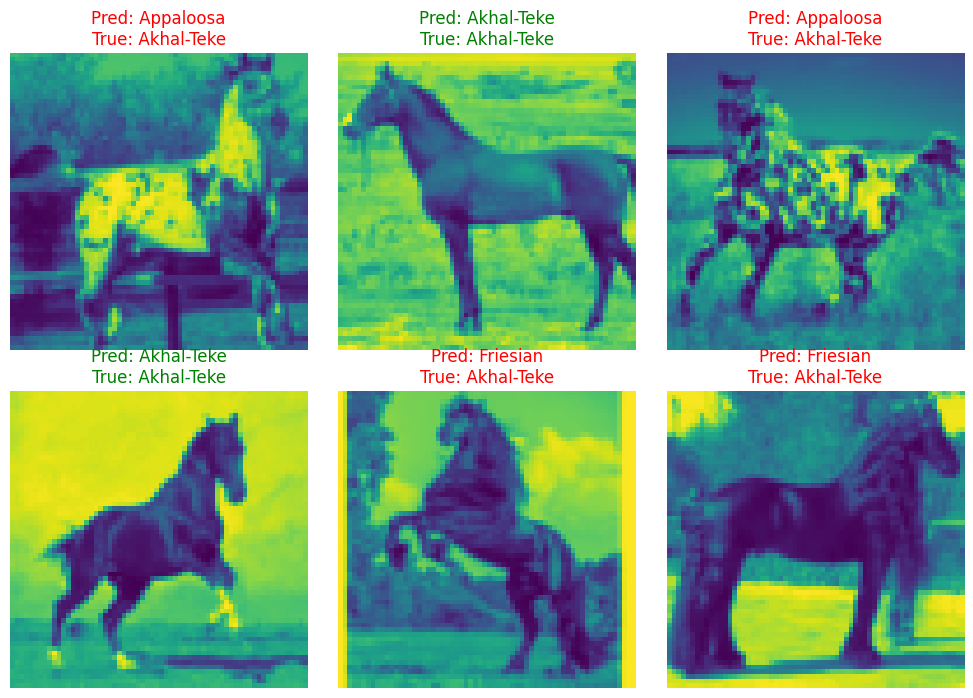

In [107]:
import matplotlib.pyplot as plt

num_images = 6  # Adjust based on batch size
fig, axes = plt.subplots(2, 3, figsize=(10, 7))  # Create a 2x3 grid

for i in range(num_images):
    img = to_pil(images[i])  # Convert to PIL
    pred_label = labels[i]  # Model prediction (string)
    true_label = dataset[i][1]  # Actual label from dataset

    ax = axes[i // 3, i % 3]  # Access the correct subplot (2 rows, 3 cols)
    ax.imshow(img)

    # Change title color based on correctness
    color = "green" if pred_label == true_label else "red"
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    ax.axis("off")

plt.tight_layout()
plt.show()



In [108]:
#Accuracy :
correct = sum(1 for pred, true in zip(labels, [dataset[i][1] for i in range(len(labels))]) if pred == true)
accuracy = correct / len(labels) * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 28.12%


## Visualization Only

In [ ]:
'''
Debugging Checklist

Before running this visualization: ✔ Check dataset size → print(len(dataset))
✔ Check first image → image, label = dataset[0]; print(image.shape, label)
✔ Check DataLoader output → images, labels = next(iter(dataloader)); print(images.shape, labels)
'''

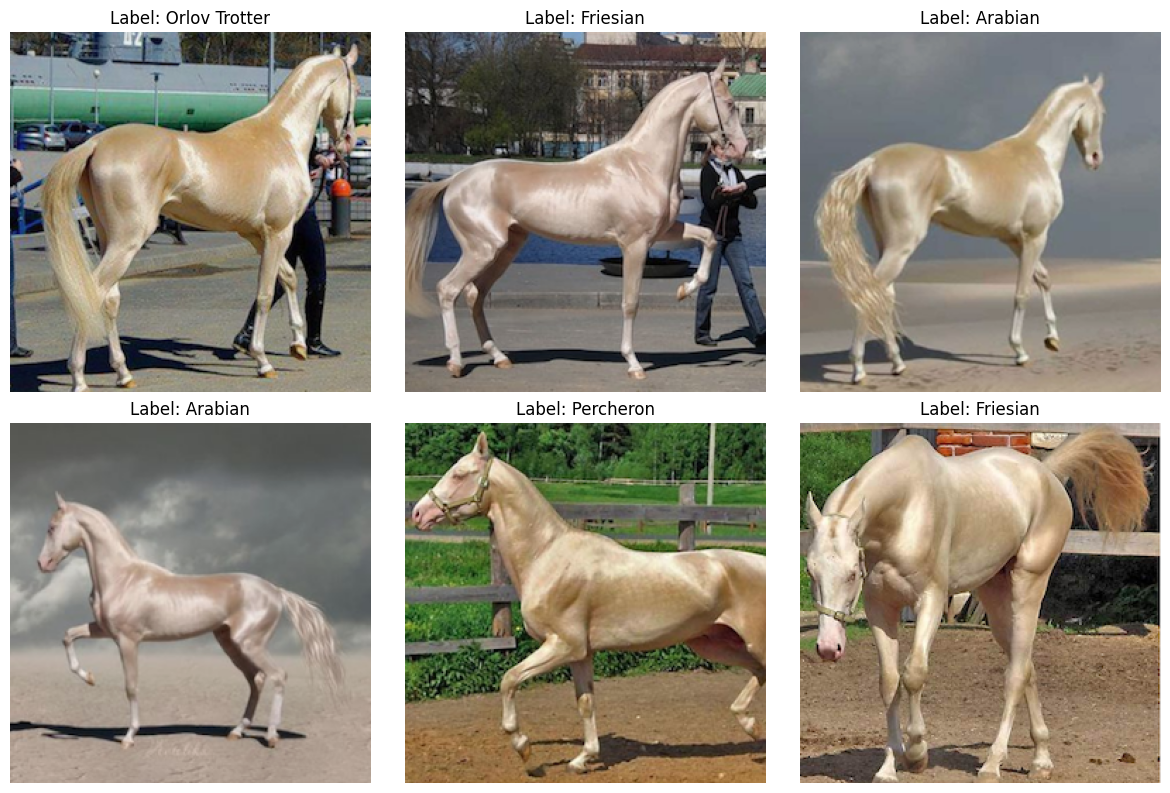

In [83]:
import matplotlib.pyplot as plt
from PIL import Image

# Define number of images to display
num_images = min(6, len(file_names))  # Limit to 6 images for display

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i in range(num_images):
    image_path = file_names[i]  # Get image file path
    label = labels[i]  # Get corresponding label

    # Load image using PIL (open the individual file, not the whole list)
    image = Image.open(image_path)

    # Plot the image
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(f"Label: {label}")
    ax.axis("off")  # Hide axes for better visualization

plt.tight_layout()
plt.show()


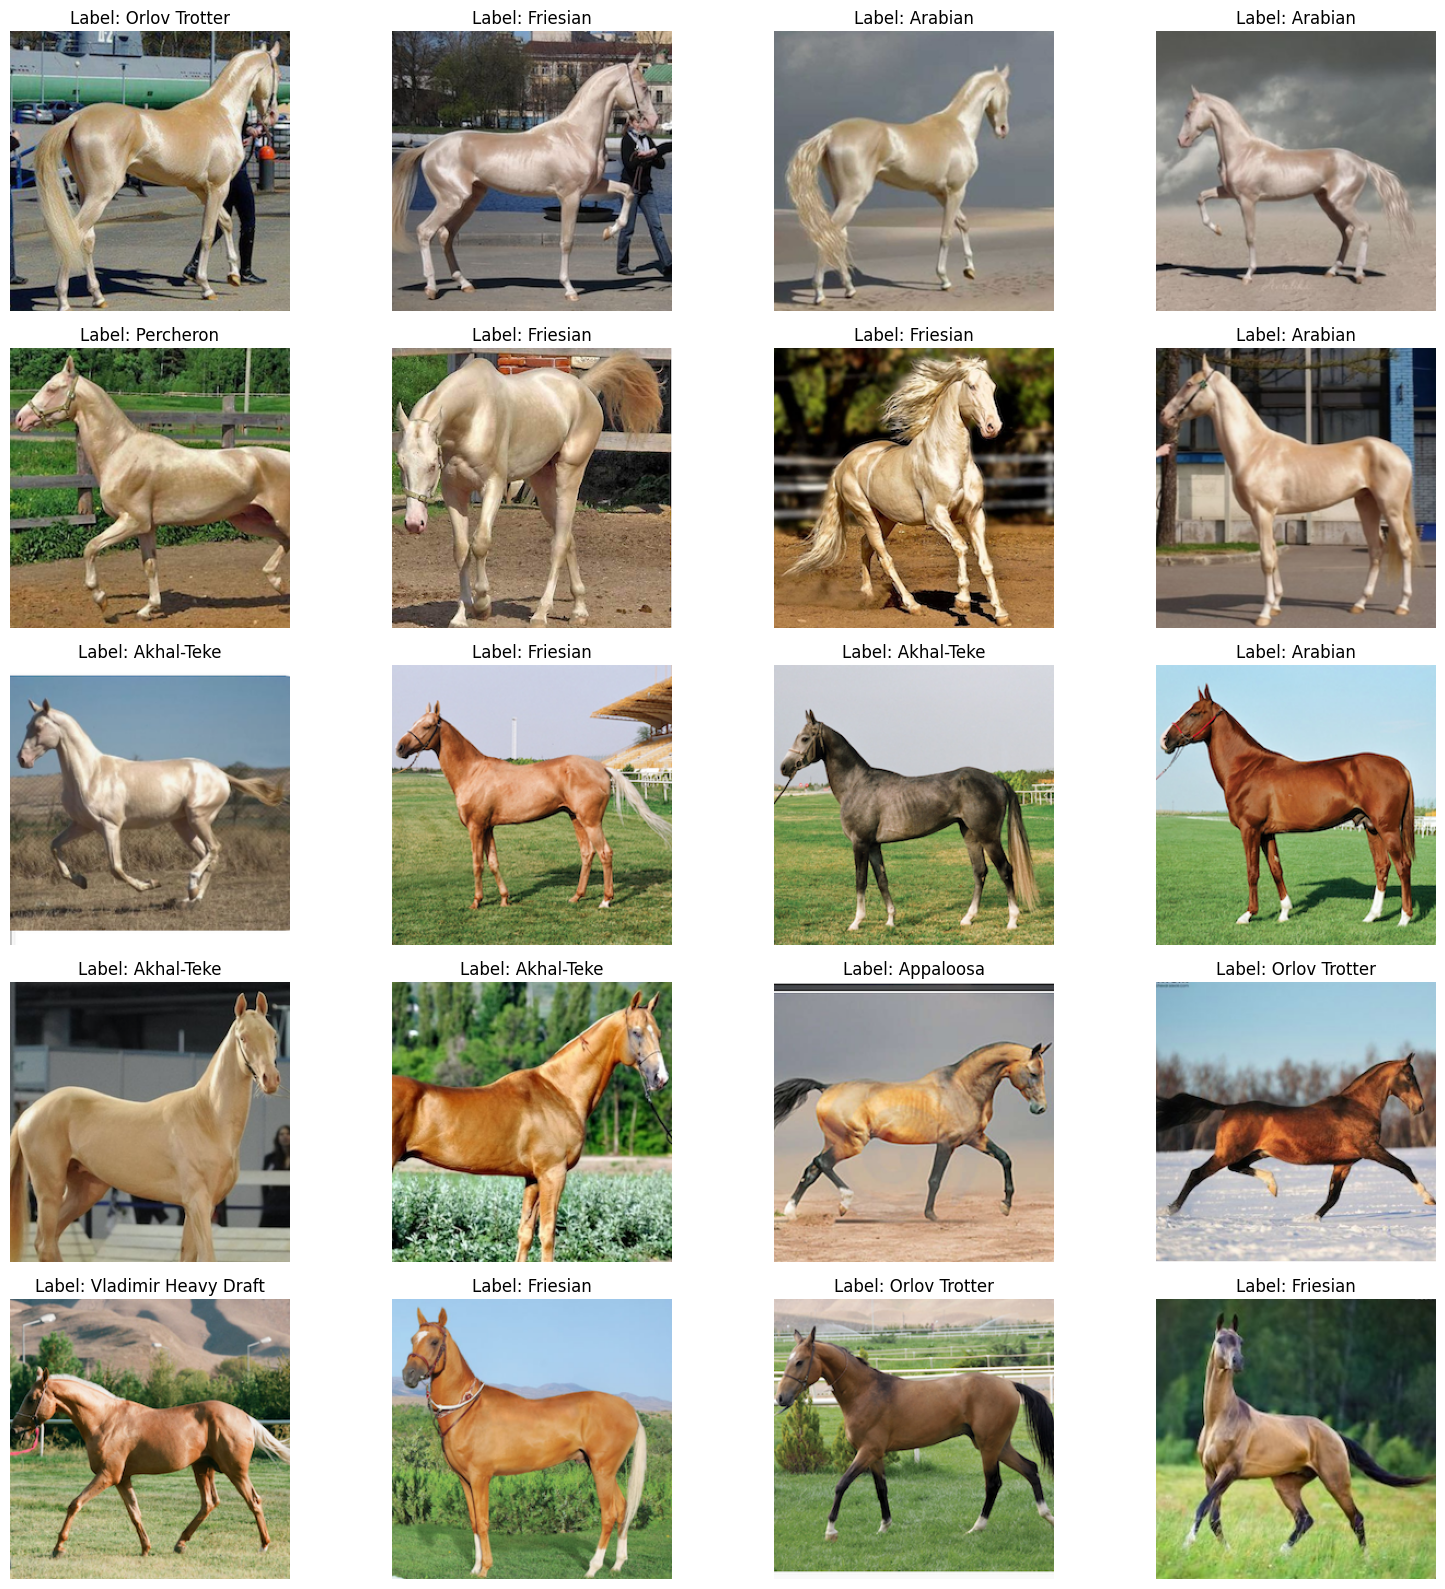

In [84]:
import matplotlib.pyplot as plt
from PIL import Image

# Define number of images to display (at least 20)
num_images = min(20, len(file_names))  # Limit to 20 images for display, or less if there are fewer

# Create a figure with subplots (5 rows, 4 columns)
fig, axes = plt.subplots(5, 4, figsize=(16, 16))

# Loop through and display the images
for i in range(num_images):
    image_path = file_names[i]  # Get image file path
    label = labels[i]  # Get corresponding label

    # Load image using PIL
    image = Image.open(image_path)

    # Calculate the row and column position
    ax = axes[i // 4, i % 4]  # 4 columns per row

    # Plot the image
    ax.imshow(image)
    ax.set_title(f"Label: {label}")
    ax.axis("off")  # Hide axes for better visualization

# Adjust layout
plt.tight_layout()
plt.show()


#### Optional: You can explore more datasets types like TensorDataset, StackDataset here: [Link](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset)

In [ ]:
xml data in : Copy_Day3_2_1_Object_Detection_FasterRCNN.ipynb

### Contributed by: Mohamed Eltayeb

![image.png](https://i.imgur.com/a3uAqnb.png)